In [81]:
%matplotlib inline
import numpy as np
import pandas as pd
import folium
import matplotlib as mpl

from matplotlib import pyplot as plt
from scipy.spatial import distance_matrix

from scipy.spatial import ConvexHull
from shapely.geometry import Polygon, Point, MultiPoint
from numpy import random
from sklearn.neighbors import KDTree
import multiprocessing as mp
import geopandas as gpd

%matplotlib inline
%config InlineBackend.figure_formats = ['png']

###  Population Distribution

In [82]:
%%time
ls_pop = gpd.read_file("./population.shp")
ls_pop.head()

CPU times: user 241 ms, sys: 45.4 ms, total: 286 ms
Wall time: 309 ms


,id,left,top,right,bottom,NUMPOINTS,geometry
0,7.0,-9.789447e+06,5.161431e+06,-9.788947e+06,5.160931e+06,98.0,POINT (-9789192.340 5161030.883)
1,8.0,-9.789447e+06,5.160931e+06,-9.788947e+06,5.160431e+06,5.0,POINT (-9789034.856 5160614.450)
2,8.0,-9.789447e+06,5.160931e+06,-9.788947e+06,5.160431e+06,5.0,POINT (-9789239.640 5160821.023)
3,9.0,-9.789447e+06,5.160431e+06,-9.788947e+06,5.159931e+06,0.0,POINT (-9789119.456 5160154.758)
4,10.0,-9.789447e+06,5.159931e+06,-9.788947e+06,5.159431e+06,0.0,POINT (-9789188.378 5159682.126)


In [83]:
ls_pop['easting'] = ls_pop.geometry.x
ls_pop['northing'] = ls_pop.geometry.y

In [84]:
value_field = 'NUMPOINTS'

In [85]:
total_pop = sum(ls_pop[value_field])
print("The number of records is ", len(ls_pop))
print("The total population are ", total_pop)

The number of records is  4732
The total population are  2856936.0


### Sound Nodes Location
The sound nodes data were retrieved from AoT 

In [86]:
%%time
site_nodes = gpd.read_file("./sound nodes.shp")
site_nodes.head()

CPU times: user 14.8 ms, sys: 4.16 ms, total: 18.9 ms
Wall time: 20 ms


,node_id,project_id,vsn,address,lat,lon,descriptio,start_time,end_timest,geometry
0,001e0610ba46,AoT_Chicago,004,State St & Jackson Blvd Chicago IL,41.878377,-87.627678,AoT Chicago (S) [C],2017/10/09 00:00:00.000,None,POINT (-9754668.494 5142778.283)
1,001e0610ba13,AoT_Chicago,01C,7801 S Lawndale Ave Chicago IL,41.751238,-87.712990,AoT Chicago (S) [C] {ComEd},2018/01/01 00:00:00.000,None,POINT (-9764165.383 5123788.634)
2,001e0610bc10,AoT_Chicago,01F,State St & 87th Chicago IL,41.736314,-87.624179,AoT Chicago (S) [C],2018/02/22 00:00:00.000,None,POINT (-9754278.987 5121562.034)
3,001e0610ba15,AoT_Chicago,02A,Jeffrey Ave & 95th St Chicago IL,41.722457,-87.575350,AoT Chicago (S) [C],2018/02/22 00:00:00.000,None,POINT (-9748843.368 5119495.090)
4,001e0610bbe5,AoT_Chicago,02C,Martin Luther King Dr & 87th St Chicago IL,41.736495,-87.614529,AoT Chicago (S) [C],2018/02/16 00:00:00.000,None,POINT (-9753204.754 5121589.036)


In [87]:
print("The number of sound nodes is ", len(site_nodes))

The number of sound nodes is  35


In [88]:
site_nodes['POINT_X'] = site_nodes.geometry.x
site_nodes['POINT_Y'] = site_nodes.geometry.y

In [89]:
sites = np.array(site_nodes[['POINT_X', 'POINT_Y']], dtype=np.float64)

print("The number of sound nodes in Chicago is ", sites.shape[0])
site_nodes.head(3)

The number of sound nodes in Chicago is  35


,node_id,project_id,vsn,address,lat,lon,descriptio,start_time,end_timest,geometry,POINT_X,POINT_Y
0,001e0610ba46,AoT_Chicago,004,State St & Jackson Blvd Chicago IL,41.878377,-87.627678,AoT Chicago (S) [C],2017/10/09 00:00:00.000,None,POINT (-9754668.494 5142778.283),-9.754668e+06,5.142778e+06
1,001e0610ba13,AoT_Chicago,01C,7801 S Lawndale Ave Chicago IL,41.751238,-87.712990,AoT Chicago (S) [C] {ComEd},2018/01/01 00:00:00.000,None,POINT (-9764165.383 5123788.634),-9.764165e+06,5.123789e+06
2,001e0610bc10,AoT_Chicago,01F,State St & 87th Chicago IL,41.736314,-87.624179,AoT Chicago (S) [C],2018/02/22 00:00:00.000,None,POINT (-9754278.987 5121562.034),-9.754279e+06,5.121562e+06


### Visualization of the output data

In [90]:
def render_scale_bar(ax, x, y, segments=2, height=0.01, seg_length=2000, unit='m', linewidth=1.):
    unit_scale_factor = {
        'm': 1,
        'km': 1000,
        'meters': 1,
        'kilometers': 1000,
        'miles': 1609.34,
        'mi': 1609.34,
        'ft': 0.3,
        }
    x_lim = ax.get_xlim()
    y_lim = ax.get_ylim()

    # how much percent does one unit takes on the x axis
    x_per_unit = 1. / (x_lim[1] - x_lim[0])
    y_per_unit = 1. / (y_lim[1] - y_lim[0])
    
    # base for ticks (0, 1)
    x_base = [x + seg_length * unit_scale_factor[unit] * x_per_unit * i for i in range(0, segments + 1)]  
    ax.axhline(y_lim[0] + y / y_per_unit, x_base[0], x_base[-1], c='black')
    y_base = [y, y + height]
    for i in range(segments + 1):
        ax.axvline(x_lim[0] + x_base[i] / x_per_unit, y, y + height, c='black')
        xy = (x_lim[0] + x_base[i] / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit)  # data_coords
        ax.text(xy[0], xy[1], s='{}'.format(int(seg_length * i)), horizontalalignment='center', verticalalignment='center')
    ax.text(x_lim[0] + (x_base[-1] + 0.02) / x_per_unit, y_lim[0] + (y - 0.015) / y_per_unit, 
            s=unit, horizontalalignment='left',
            verticalalignment='center')

In [91]:
def render_north_arrow(ax, x, y, size, ratio = 1):
    path = [(0, 1), (-ratio, -1), (0, -0.5), (ratio, -1), (0, 1)]
    path = [(i[0] * size + x, i[1] * size + y) for i in path]
    arrow = plt.Polygon(path, color='black', transform=ax.transAxes)
    ax.add_patch(arrow)
    ax.text(x, y-size*2, s = 'N', horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)

In [92]:
sites.tolist()

[[-9754668.494356941, 5142778.283298],
 [-9764165.382755497, 5123788.633870652],
 [-9754278.987458656, 5121562.034283699],
 [-9748843.368042711, 5119495.089903424],
 [-9753204.7543725, 5121589.035641418],
 [-9752176.05095808, 5123797.139029072],
 [-9769517.846511818, 5149601.203869857],
 [-9758968.543647304, 5141045.473166616],
 [-9758828.503727887, 5132350.735593338],
 [-9758750.023486877, 5129089.856794136],
 [-9751440.117804445, 5129772.611182118],
 [-9764165.382755497, 5123774.309410385],
 [-9753512.998042507, 5135708.042374285],
 [-9751364.197911723, 5129421.747278641],
 [-9759001.160258107, 5142153.801570879],
 [-9760829.360255403, 5148119.845362321],
 [-9760096.655367002, 5141747.170339838],
 [-9756157.503865791, 5134581.19071313],
 [-9752117.16294745, 5121603.6551928185],
 [-9758532.727840848, 5145436.936175084],
 [-9751444.125306115, 5129366.356748594],
 [-9761350.446791807, 5149736.907071838],
 [-9767819.667679768, 5145264.654580546],
 [-9752883.49745402, 5144815.735048174],


## Solving the spatial optimization model for sound sensor deployment in Chicago

In [93]:
ls_pop['POINT_X'] = ls_pop.geometry.x
ls_pop['POINT_Y'] = ls_pop.geometry.y
ls_pop.head(3)

,id,left,top,right,bottom,NUMPOINTS,geometry,easting,northing,POINT_X,POINT_Y
0,7.0,-9.789447e+06,5.161431e+06,-9.788947e+06,5.160931e+06,98.0,POINT (-9789192.340 5161030.883),-9.789192e+06,5.161031e+06,-9.789192e+06,5.161031e+06
1,8.0,-9.789447e+06,5.160931e+06,-9.788947e+06,5.160431e+06,5.0,POINT (-9789034.856 5160614.450),-9.789035e+06,5.160614e+06,-9.789035e+06,5.160614e+06
2,8.0,-9.789447e+06,5.160931e+06,-9.788947e+06,5.160431e+06,5.0,POINT (-9789239.640 5160821.023),-9.789240e+06,5.160821e+06,-9.789240e+06,5.160821e+06


In [94]:
from gurobipy import *
import time

In [95]:
def generate_candidate_sites(sites, M):
    '''
    Generate M candidate sites with the convex hull of a point set
    Input:
        sites: a Pandas DataFrame with X, Y and other characteristic
        M: the number of candidate sites to generate
        heuristic: 
    Return:
        sites: a Numpy array with shape of (M,2)
    '''
    if M is not None:
        if M > len(sites):
            M = None
    if M is None:
        return sites
    index = np.random.choice(len(sites), M)
    return sites.iloc[index]

### Model

In [96]:
def bclp_gurobi(ls_pop, sensors, current_sensors, K, radius, M):

    print('----- Configurations -----')
    print('Number of points %g' % len(ls_pop))
    print('Number of sound sensor %g' % K)
    print('Number of current sound sensor %g' % len(current_sensors))
    print('Number of selected sound sensor - K %g', K-len(current_sensors))
    print('Sound sensors coverage Radius %g (Meter)' % radius)
    print('Number of candidate sound sensor sampled - M %g' % M)

    sites_candidate = generate_candidate_sites(sensors, M) 
    current_sensors = pd.DataFrame(current_sensors, columns=['POINT_X','POINT_Y'])
    current_sensors['current'] = True
    sites_candidate.loc['current'] = False
    
    sensors = current_sensors.append(sites_candidate, ignore_index=True, verify_integrity=True)
    sensors = sensors.reset_index()

    J = len(sensors)  # indexing for facility sites
    I = len(ls_pop)  # indexing for population (clients)
    D = distance_matrix(ls_pop[['easting', 'northing']].values, sensors[['POINT_X', 'POINT_Y']].values)
    mask1 = D <= radius
    D[mask1] = 1
    D[~mask1] = 0
  
    pop = ls_pop[value_field]
    start = time.time()

    # Build model
    m = Model()

    # Add variables
    x = {}  #Select
    y = {}  #Serve
    u = {}  #Twice
    
    current = len(current_sensors)

    for i in range(I):
        y[i] = m.addVar(vtype=GRB.BINARY, name='y%d' % i)

    for i in range(I):
        u[i] = m.addVar(vtype=GRB.BINARY, name='u%d' % i)
        
    for j in range(J):
        x[j] = m.addVar(vtype=GRB.BINARY, name='x%d' % j)
        
    m.update()

    # the number of facilities
    m.addConstr(quicksum(x[j] for j in range(J)) == K)
    
    for i in range(I):
        m.addConstr(u[i] - y[i] <= 0)
        
    for i in range(I):
        m.addConstr(quicksum(x[j] for j in np.where(D[i] == 1)[0]) - y[i] - u[i] >=0 )
    
    for j in range(current):
        m.addConstr(x[j] == 1)

    # objective
    m.setObjective(0.0 * quicksum(y[i] * pop[i] for i in range(I)) + 1.0 * quicksum(u[i] * pop[i] for i in range(I)),
                   GRB.MAXIMIZE)

    m.setParam('OutputFlag', 0)
    m.optimize()
    end = time.time()
    
    print('  Running time : %s seconds' % float(end-start))
    print('  Optimal coverage points: %g' % m.objVal)

    solution = []
    if m.status == GRB.Status.OPTIMAL:
        for v in m.getVars():
            if v.x == 1 and v.varName[0] == 'x':
                solution.append(int(v.varName[1:]))
    opt_sensors = sensors.iloc[solution]
    return (opt_sensors)

In [97]:
BCLP_STAT = pd.DataFrame({
    'integrate_current_sites': pd.Series([], dtype='bool'),
    'M': pd.Series([], dtype='int'),
    'radius': pd.Series([], dtype='int'),
    'K': pd.Series([], dtype='int'),
    'opt_sites': pd.Series([], dtype='object')
})

In [98]:
def plot_result(ls_pop,opt_sites,radius):
    '''
    Plot the result
    Input:
        points: input points, Numpy array in shape of [N,2]
        opt_sites: locations K optimal sites, Pandas DataFrame
        radius: the radius of circle
    '''
    fig, ax = plt.subplots(figsize=(20,15))
    ls_pop.plot(ax = ax, column=ls_pop[value_field], scheme = 'natural_breaks', k=8, markersize=20, cmap='Blues',legend=True, label='Population', legend_kwds={
                                                     'loc': 'center left',
                                                     'title': 'population',
                                                     'shadow': False
                                                 })
    legend_plot_flag = {'current':False,'selected':False}
    
    for cnt, site in opt_sites.iterrows():
        if 'current' in opt_sites.columns and site['current'] == True:#ncurrent
            if legend_plot_flag['current'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='Salmon', marker='+', s=50, label = 'Current Sound Sensors')
                circlelabel = 'Service Range for Current Sound Sensors'
                legend_plot_flag['current'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='Salmon', marker='+', s=100)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='Salmon', fill=False, lw=2)
            ax.add_artist(circle)
        else:
            if legend_plot_flag['selected'] == False:
                ax.scatter(site['POINT_X'], site['POINT_Y'], c='SlateBlue', marker='+', s=50, label = 'Optimized Sound Sensors')
                circlelabel = 'Service Range for Optimized Sound Sensors'
                legend_plot_flag['selected'] = True
            ax.scatter(site['POINT_X'], site['POINT_Y'], c='SlateBlue', marker='+', s=100)
            circle = plt.Circle(site[['POINT_X','POINT_Y']], radius, color='SlateBlue', fill=False, lw=2)
            ax.add_artist(circle)
        
    ax.axis('scaled')
    ax.tick_params(axis='both',left=False, top=False, right=False,
                       bottom=False, labelleft=False, labeltop=False,
                       labelright=False, labelbottom=False)
    title = 'Selected ' + str(len(opt_sites)) + ' Sites that Serve ' + str(radius) + ' m'
    ax.set_title(title, fontsize=20)
    render_scale_bar(ax = ax, x=0.05, y=0.05)
    render_north_arrow(ax = ax, x = 0.95, y = 0.95, size = 0.01, ratio = 0.7)
    ax.legend(loc='center left', markerscale = 1)
    return ax

----- Configurations -----
Number of points 4732
Number of sound sensor 45
Number of current sound sensor 35
Number of selected sound sensor - K %g 10
Sound sensors coverage Radius 1000 (Meter)
Number of candidate sound sensor sampled - M 4732


<ipython-input-96-f77d0c0ded05>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sites_candidate.loc['current'] = False
<ipython-input-96-f77d0c0ded05>:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sensors = current_sensors.append(sites_candidate, ignore_index=True, verify_integrity=True)


  Running time : 1.9388108253479004 seconds
  Optimal coverage points: 888808


<timed exec>:13: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


CPU times: user 19.5 s, sys: 1.38 s, total: 20.9 s
Wall time: 10.3 s


<Axes: title={'center': 'Selected 45 Sites that Serve 1000 m'}>

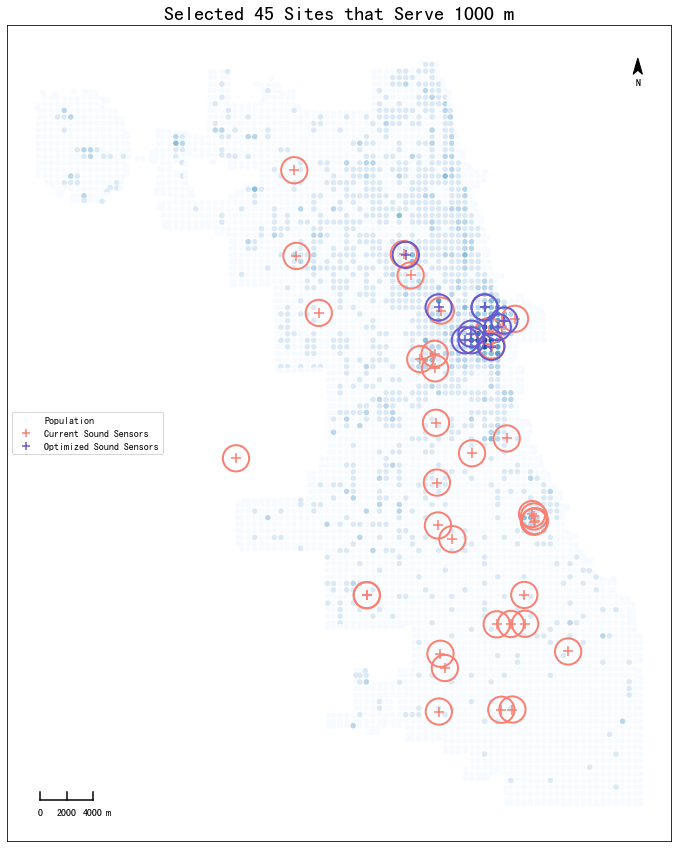

In [99]:
%%time
# Number of sites to select
K = 45

# Service radius of each site
radius =1000

M = len(ls_pop)

current_sites =sites.tolist()

opt_sites = bclp_gurobi(ls_pop, ls_pop, current_sites, K, radius, M)

BCLP_STAT = BCLP_STAT.append({
    'integrate_current_sites':True,
    'M': M,
    'radius': radius,
    'K': K,
    'opt_sites': opt_sites
}, ignore_index = True)

plot_result(ls_pop,opt_sites,radius)


### Outputs the location of the sound sensor to be deployed

In [100]:
opt_sites

,index,POINT_X,POINT_Y,current,id,left,top,right,bottom,NUMPOINTS,geometry,easting,northing
0,0,-9754668.494357,5142778.283298,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,-9764165.382755,5123788.633871,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,-9754278.987459,5121562.034284,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,-9748843.368043,5119495.089903,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,-9753204.754372,5121589.035641,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,5,-9752176.050958,5123797.139029,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,6,-9769517.846512,5149601.20387,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,7,-9758968.543647,5141045.473167,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,8,-9758828.503728,5132350.735593,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,9,-9758750.023487,5129089.856794,True,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
opt_sites['POINT_X']=opt_sites['POINT_X'].astype(float)
opt_sites['POINT_Y']=opt_sites['POINT_Y'].astype(float)

### Calculating the coverage of sound sensors

In [102]:
radius = 1000
D = distance_matrix(opt_sites[['POINT_X', 'POINT_Y']].values, ls_pop[['easting', 'northing']].values)
mask1 = D <= radius
D[mask1] = 1
D[~mask1] = 0

backup_cover = np.sum(D, axis=0)

cover_once = [1 if x == 1 else 0 for x in backup_cover]
index_once = np.where(np.array(cover_once) == 1)[0]
print("Covered once points: %s" % index_once)

cover_multi = [1 if y >= 2 else 0 for y in backup_cover]
index_multi = np.where(np.array(cover_multi) == 1)[0]
print("Covered twice points: %s" % index_multi)

cover_all = [1 if z >= 1 else 0 for z in backup_cover]
index_all = np.where(np.array(cover_all) == 1)[0]
print("Covered all points: %s" % index_all)


total_once = 0
for index1 in index_once:
#     print(index1)
    value_once = ls_pop.iloc[index1,5]
    total_once += value_once
print("The number of population coverd once is: %s" % total_once)
print("The percent of population coverd once is: %s" % (total_once/total_pop))
count_of_once = len(index_once)
print("The number of point coverd once is: %s" % count_of_once)

total_twice = 0
for index2 in index_multi:
    value_twice = ls_pop.iloc[index2,5]
    total_twice += value_twice
print("The number of population coverd twice is: %s" % total_twice)
print("The percent of population coverd twice is: %s" % (total_twice/total_pop))
count_of_twice = len(index_multi)
print("The number of point coverd twice is: %s" % count_of_twice)

total = 0
for index3 in index_all:
    value = ls_pop.iloc[index3,5]
    total += value
print("The number of population coverd is: %s" % total)
print("The percent of population coverd is: %s" % (total/total_pop))
count_of_all = len(index_all)
print("The number of point coverd is: %s" % count_of_all)

Covered once points: [ 797  798  799  810  811  812  850  851  852  853  863  864  865  866
  901  902  903  914  915  916  917  952  965  966  973  974 1026 1027
 1028 1029 1080 1081 1082 1083 1137 1138 1139 2021 2119 2120 2215 2216
 2312 2313 2314 2315 2325 2326 2327 2414 2416 2417 2418 2428 2429 2430
 2431 2526 2532 2536 2543 2544 2552 2553 2559 2636 2640 2641 2646 2647
 2648 2649 2655 2656 2657 2658 2662 2663 2664 2682 2683 2684 2685 2690
 2691 2692 2693 2732 2740 2741 2743 2744 2745 2750 2751 2752 2753 2759
 2760 2761 2762 2766 2767 2768 2769 2785 2786 2787 2789 2790 2794 2795
 2796 2797 2838 2842 2843 2845 2846 2853 2854 2862 2863 2864 2868 2869
 2871 2872 2887 2888 2891 2892 2896 2897 2898 2899 2940 2944 2973 2974
 2975 2976 2991 2992 2993 2994 2995 3041 3069 3070 3071 3072 3135 3149
 3150 3151 3163 3225 3230 3244 3245 3246 3247 3337 3338 3339 3428 3454
 3455 3497 3536 3537 3538 3539 3549 3550 3551 3586 3587 3588 3614 3616
 3617 3627 3628 3629 3630 3641 3659 3660 3661 3662 3704 